In [7]:
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.config import set_default_float
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [5]:
# 1. Synthetic data
NUM_CLASSES = 7
NUM_TRAIN   = 700
NUM_TEST    = 200
DIM         = 2

X, y = make_blobs(
    n_samples=NUM_TRAIN + NUM_TEST,
    centers=NUM_CLASSES,
    n_features=DIM,
    cluster_std=1.0,
    random_state=42,
)
x_train, y_train = X[:NUM_TRAIN], y[:NUM_TRAIN]
x_test,  y_test  = X[NUM_TRAIN:], y[NUM_TRAIN:]
Y_train = y_train.reshape(-1, 1).astype(np.int64)

In [6]:
# 2. Build SVGP
set_default_float(np.float64)
kernel     = gpflow.kernels.SquaredExponential(lengthscales=[1.0]*DIM)
likelihood = gpflow.likelihoods.MultiClass(num_classes=NUM_CLASSES)
# pick M inducing points
M = 50
Z = x_train[np.random.choice(NUM_TRAIN, M, replace=False)].copy()

model = gpflow.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=Z,
    num_latent_gps=NUM_CLASSES,
    whiten=True,
)

In [ ]:
# 3. Adam optimizer + minibatch pipeline
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices((x_train, Y_train)) \
                         .shuffle(NUM_TRAIN).batch(batch_size).repeat()

opt = tf.optimizers.Adam(learning_rate=0.01)
num_steps = 2000
loss_history = []

In [11]:
# 4. Training loop
train_iter = iter(train_ds)  # endless iterator
for step in tqdm(range(num_steps), desc="Training SVGP"):
    Xb, Yb = next(train_iter)  # grab the next minibatch
    with tf.GradientTape() as tape:
        loss = model.training_loss((Xb, Yb))   # negative ELBO
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    # record the ELBO (positive) rather than its negative
    loss_history.append(-loss.numpy())

Training SVGP: 100%|██████████| 2000/2000 [01:08<00:00, 29.22it/s]


In [12]:
# 5. Evaluate
probs, _ = model.predict_y(x_test)
y_pred   = np.argmax(probs, axis=1)
acc      = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc*100:.1f}%")

Test accuracy: 92.0%


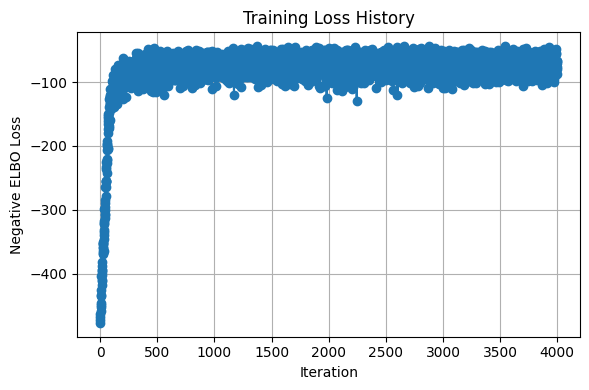

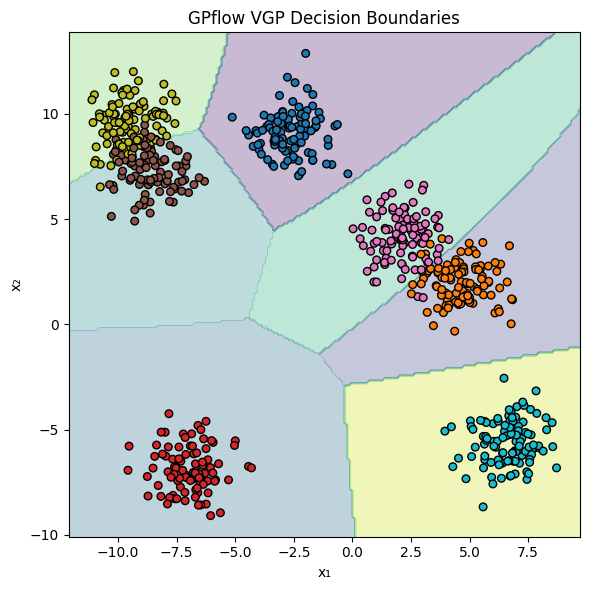

In [13]:
import matplotlib.pyplot as plt

# --- Plot 1: ELBO (actually negative loss) over iterations ---
plt.figure(figsize=(6,4))
plt.plot(loss_history, marker='o', linestyle='-')
plt.xlabel("Iteration")
plt.ylabel("Negative ELBO Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: 2D decision boundary ---
# Create a grid over the feature space
x0_min, x0_max = x_train[:,0].min() - 1, x_train[:,0].max() + 1
x1_min, x1_max = x_train[:,1].min() - 1, x_train[:,1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x0_min, x0_max, 200),
    np.linspace(x1_min, x1_max, 200)
)
grid = np.column_stack([xx.ravel(), yy.ravel()])

# Predict class probabilities on the grid
fmean_grid, _ = model.predict_f(grid)
Z = np.argmax(fmean_grid, axis=1).reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(NUM_CLASSES+1)-0.5)
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, s=30, edgecolor='k', cmap='tab10')
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.title("GPflow VGP Decision Boundaries")
plt.tight_layout()
plt.show()
